In [58]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
from datacube import helpers

In [60]:
help(helpers.write_geotiff)

Help on function write_geotiff in module datacube.helpers:

write_geotiff(filename, dataset, profile_override=None, time_index=None)
    Write an ODC style xarray.Dataset to a GeoTIFF file.
    
    :param filename: Output filename
    :param dataset: xarray dataset containing one or more bands to write to a file.
    :param profile_override: option dict, overrides rasterio file creation options.
    :param time_index: DEPRECATED



In [61]:
#load modules
import datacube
from datacube.storage import masking
from datacube import Datacube
from datetime import datetime
from skimage import exposure

import rasterio
from datacube_stats.statistics import GeoMedian
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from scipy import ndimage

import geopandas as gpd
from sklearn.ensemble import ExtraTreesClassifier
import datacube_stats
import os
# Replace '156' and 'ck9738' with the path to your own home directory on the VDI
s2aws = Datacube(config='/home/547/ck9738/datacube-s2.conf')

In [62]:
#define nessisary gotiff handeling fuctions

import xarray, rasterio, numpy as np
def numpy_to_xarray(array, geobox, name=None):
    """Utility to convert ndarray to DataArray, using a datacube.model.GeoBox"""
    coords=[xarray.Coordinate(x, geobox.coords[x].values, attrs=dict(units=geobox.coords[x].units)) 
            for x in geobox.dims]
    return xarray.DataArray(array, coords=coords, attrs=dict(crs=geobox.crs), name=name)

def geopandas_to_xarray(table, geobox, name=None):
    """Rasterise (with reprojection)"""
    array = rasterio.features.rasterize(shapes=table.to_crs(geobox.crs._crs.ExportToProj4()).geometry,
                                        out_shape=(geobox.height, geobox.width),
                                        transform=geobox.affine)
    return numpy_to_xarray(array, geobox, name)

def rasterfile_to_xarray(file, geobox, name=None, nodata=True, num_bands=(1), X_band= 1):
    """Blit like
    """
    with rasterio.open(file) as src:

        #|assert src.indexes == num_bands # assume single band
        band = rasterio.band(src, X_band) # do not attempt to read entire extent into memory
        array = np.empty((geobox.height, geobox.width), dtype=band.dtype)
        rasterio.warp.reproject(source=band,
                                destination=array,
                                dst_crs=geobox.crs.crs_str,
                                dst_transform=geobox.affine,
                                dst_nodata=nodata)
    return numpy_to_xarray(array, geobox, name)

In [63]:
def create_slope(dem_data):
    """this is a rough and ready way to get a slope map out of a DEM, it is based on Numpy modules 
    and the definition slope = tan-1(rize/run). the product is a map of 'maximum slope' along either axis of the array
    
    input= DEM. digital elevation model DataSet from dc.load(product='dsm1sv10')
    Output= DEM DataSet with Slope added as a variable """
    
    elevation = dem_data.elevation[0,:,:]# get the 2D DataArray from the dataset

    #convert the elevation data to gradient using g=rize over run
    datagrad2,datagrad3 = np.gradient(elevation, axis=(0,1))

    #convert to degrees slope using slope = tan-1(gradient).
 
    dataslope_ns = np.rad2deg(np.arctan(datagrad2))
    dataslope_ew = np.rad2deg(np.arctan(datagrad3))

    #turn angle of slope into absolute values as we don't acually want negative slope
    dataslope_ns_abs = np.absolute(dataslope_ns)
    dataslope_ew_abs = np.absolute(dataslope_ew)

    #combine N-S and E-W slopemaps into a sigle map, with largest values for each square
    dataslope_all = np.maximum(dataslope_ns_abs, dataslope_ew_abs)
    
    gsm_dataslope_all = ndimage.gaussian_filter(dataslope_all, sigma=1.5)
    
    gsm_dataslope_all = xr.DataArray(gsm_dataslope_all,dims=('y', 'x'))
    
    
    
    #dem_data['slope'] = dataslope_all
    return(gsm_dataslope_all)

In [64]:
"""#define area
# open  shapfile and data loat from that

shapefile_loc='/g/data/u46/users/ck9738/Datasets/woody_files/test_area_outline.shp'

#import project area shapefiles
project_area = gpd.read_file(shapefile_loc)

#convert the shapefile to GDA94 lat-long coords so we can query dc_load using lat long
project_area['geometry'] = project_area['geometry'].to_crs(epsg=4283)

#find the bounding box that contains all the queried projects
#addig 0.025 degrees to the bounding box to be certain the polygons are captured
coords = project_area.total_bounds
xmin, ymax, xmax, ymin =coords"""

"#define area\n# open  shapfile and data loat from that\n\nshapefile_loc='/g/data/u46/users/ck9738/Datasets/woody_files/test_area_outline.shp'\n\n#import project area shapefiles\nproject_area = gpd.read_file(shapefile_loc)\n\n#convert the shapefile to GDA94 lat-long coords so we can query dc_load using lat long\nproject_area['geometry'] = project_area['geometry'].to_crs(epsg=4283)\n\n#find the bounding box that contains all the queried projects\n#addig 0.025 degrees to the bounding box to be certain the polygons are captured\ncoords = project_area.total_bounds\nxmin, ymax, xmax, ymin =coords"

In [65]:
""" 
square 60 -149  'lat': (-33.107410, -33.216838),
near parks      'lon': (148.264306, 148.470191),

canberra east 
        'lat': (-35.219946, -35.404461),
        'lon': (149.12468, 149.413767),

square 60_-155, Barwang
        'lat': (-34.382385, -34.577689),
        'lon': (148.425899, 148.734517),

"""

" \nsquare 60 -149  'lat': (-33.107410, -33.216838),\nnear parks      'lon': (148.264306, 148.470191),\n\ncanberra east \n        'lat': (-35.219946, -35.404461),\n        'lon': (149.12468, 149.413767),\n\nsquare 60_-155, Barwang\n        'lat': (-34.382385, -34.577689),\n        'lon': (148.425899, 148.734517),\n\n"

In [66]:
#load sentinal data
sensors= ['s2a_ard_granule'] #pick the sentinal satelites you want

bands_of_int =['t_blue', 't_green', 't_red'
             #'rededge1', 
             #'rededge2', 'rededge3', 'nir1', 'nir2', 'swir1', 'swir2', 'pixel_quality'
              ] #pick the sentinal bands that you want, here i am just using visible light  

query = {
        'lat': (-35.219946, -35.404461),
        'lon': (149.12468, 149.413767),
        'output_crs': 'EPSG:3577',
        'resolution': (-10, 10),
        'time':('2016-01-01', '2016-03-30')
        }
      
# use s2b_ard_granule 	 for S2B
data_sent = s2aws.load(product='s2a_ard_granule', measurements=bands_of_int, group_by='solar_day', **query)
#clear_pixels = np.logical_and(data_sent.pixel_quality != 2, data_sent.pixel_quality != 3)

#data_sent = data_sent.where(clear_pixels)


In [67]:
data_sent

<xarray.Dataset>
Dimensions:  (time: 5, x: 2877, y: 2387)
Coordinates:
  * time     (time) datetime64[ns] 2016-01-01T00:09:15.704000 ...
  * y        (y) float64 -3.951e+06 -3.951e+06 -3.951e+06 -3.951e+06 ...
  * x        (x) float64 1.548e+06 1.548e+06 1.548e+06 1.548e+06 1.548e+06 ...
Data variables:
    t_blue   (time, y, x) int16 578 590 568 590 533 501 445 414 431 526 593 ...
    t_green  (time, y, x) int16 749 736 726 770 695 607 572 540 659 768 767 ...
    t_red    (time, y, x) int16 954 952 927 997 889 752 714 551 621 807 968 ...
Attributes:
    crs:      EPSG:3577

In [39]:
"""#generate sentinal geomedian?
#cast the data to float numbers so geomedian calculation will work
data_sent_flt = data_sent.astype(float,casting='safe')

#create geomedian for data
Sentinal_gm=GeoMedian().compute(data_sent_flt)"""


"#generate sentinal geomedian?\n#cast the data to float numbers so geomedian calculation will work\ndata_sent_flt = data_sent.astype(float,casting='safe')\n\n#create geomedian for data\nSentinal_gm=GeoMedian().compute(data_sent_flt)"

In [68]:
Sentinal_time = data_sent.isel(time=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


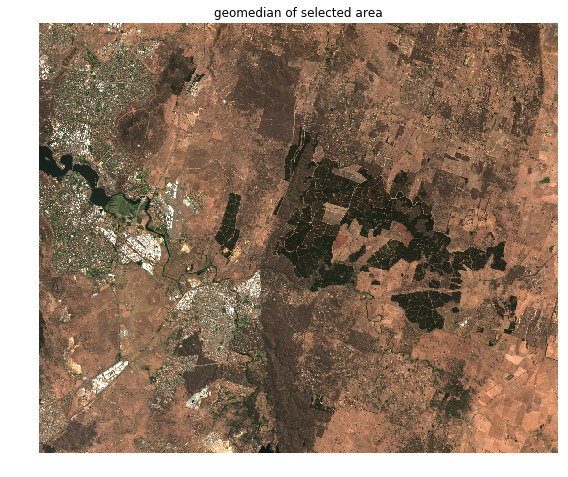

In [41]:
#plot Geomedian
#Prepare geomedian imagery for plotting

rgb = Sentinal_time.to_array(dim='color').sel(color=[
    'red','green', 'blue']).transpose('y', 'x', 'color')
fake_saturation = 2000.0  #you may need to adjust this to get a clear image. higher numbers will make it darker, 
                                                                            #lower will make it ligher
rgb = rgb.astype('double')
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

fig = plt.figure(figsize =(8,8)) #edit size of plot 
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #set border dimensions
fig.patch.set_facecolor('white') #make border white 
fig.patch.set_alpha(0.99)#ensure border white
plt.axis('off')#remove axis 
plt.title('geomedian of selected area') #add title
plt.imshow(scaled, interpolation = 'nearest') #create image

In [42]:
group_smad_green = {}
band_list = [1,2,3]

In [43]:
#load smad/green product for area
for band in band_list:

    data = rasterfile_to_xarray('/g/data/u46/users/dxr251/woody-v6/woody_62_-159.tif', data_sent.geobox, num_bands=(1,2,3), X_band=band)
    group_smad_green[band] = data

/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Coordinate has been deprecated. Use IndexVariable instead.
  import sys


In [44]:
dc = datacube.Datacube()
query = {
        'lat': (-35.219946, -35.404461),
        'lon': (149.12468, 149.413767),
        'output_crs': 'EPSG:3577',
        'resolution': (-10, 10),
        #'time':('2016-01-01', '2016-03-30')
        }
dsm = dc.load(product='dsm1sv10',**query)
dsm = create_slope(dsm)
group_smad_green[4] = dsm
group_smad_green

{1: <xarray.DataArray (y: 2387, x: 2877)>
 array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)
 Coordinates:
   * y        (y) float64 -3.951e+06 -3.951e+06 -3.951e+06 -3.951e+06 ...
   * x        (x) float64 1.548e+06 1.548e+06 1.548e+06 1.548e+06 1.548e+06 ...
 Attributes:
     crs:      EPSG:3577, 2: <xarray.DataArray (y: 2387, x: 2877)>
 array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)
 Coordinates:
   * y        (y) float64 -3.951e+06 -3.951e+06 -3.951e+06 -3.951e+06 ...
   * x        (x) float64 1.548e+06 1.548e+06 1.548e+06 1.548e+06 1.548e+06 ...
 Attributes:
   

In [45]:
data_smad_green = xr.concat([group_smad_green[1],group_smad_green[2],group_smad_green[3],group_smad_green[4]],'band')
ori_n,ori_y,ori_x=data_smad_green.shape
data_smad_green

<xarray.DataArray (band: 4, y: 2387, x: 2877)>
array([[[ 1.      ,  1.      , ...,  1.      ,  1.      ],
        [ 1.      ,  1.      , ...,  1.      ,  1.      ],
        ...,
        [ 1.      ,  1.      , ...,  1.      ,  1.      ],
        [ 1.      ,  1.      , ...,  1.      ,  1.      ]],

       [[ 1.      ,  1.      , ...,  1.      ,  1.      ],
        [ 1.      ,  1.      , ...,  1.      ,  1.      ],
        ...,
        [ 1.      ,  1.      , ...,  1.      ,  1.      ],
        [ 1.      ,  1.      , ...,  1.      ,  1.      ]],

       [[ 1.      ,  1.      , ...,  1.      ,  1.      ],
        [ 1.      ,  1.      , ...,  1.      ,  1.      ],
        ...,
        [ 1.      ,  1.      , ...,  1.      ,  1.      ],
        [ 1.      ,  1.      , ...,  1.      ,  1.      ]],

       [[54.148945, 49.4636  , ..., 38.96882 , 42.557465],
        [55.39094 , 50.657223, ..., 40.80362 , 44.515373],
        ...,
        [25.58511 , 33.71528 , ..., 10.767056, 11.498149],
        [1

In [46]:
#transform into format to feed to algorithm
flat_smad_green = data_smad_green.stack(z=('y','x')) #we stack Y and X together to make the array 2D, where shape is 
                                                  # N_samples x N_features
    
flat_smad_green = flat_smad_green.transpose()#transpose so sample numbers is first dimention. This is what the machine 
flat_smad_green                              #learning algarithm wants 

<xarray.DataArray (z: 6867399, band: 4)>
array([[ 1.      ,  1.      ,  1.      , 54.148945],
       [ 1.      ,  1.      ,  1.      , 49.4636  ],
       [ 1.      ,  1.      ,  1.      , 44.077354],
       ...,
       [ 1.      ,  1.      ,  1.      , 10.438774],
       [ 1.      ,  1.      ,  1.      , 11.538981],
       [ 1.      ,  1.      ,  1.      , 12.401855]], dtype=float32)
Coordinates:
  * z        (z) MultiIndex
  - y        (z) float64 -3.951e+06 -3.951e+06 -3.951e+06 -3.951e+06 ...
  - x        (z) float64 1.548e+06 1.548e+06 1.548e+06 1.548e+06 1.548e+06 ...
Dimensions without coordinates: band

In [47]:
#load traning data
panda_training= pd.read_csv('/g/data/u46/users/ck9738/Datasets/ML_for_smad_green/training_datasets/ncas_truthed_landsat_wslope_3.csv',
                            usecols=(1,2,3,4,5))

panda_training

,class,slope,1,2,3
0,0,65.517620,0.011901,0.478185,0.448217
1,0,63.499850,0.007710,0.443336,0.430334
2,0,59.859222,0.006552,0.452418,0.443837
3,0,55.612732,0.006581,0.444237,0.442053
4,0,52.008205,0.006155,0.424542,0.444962
5,0,49.297665,0.006485,0.437431,0.445485
6,0,46.223106,0.004184,0.419859,0.421206
7,0,41.650960,0.001740,0.341268,0.346248
8,0,36.719547,0.002779,0.343427,0.338281
9,0,34.524200,0.002023,0.325734,0.328925


In [48]:
training_features = panda_training.as_matrix(columns=['1','2','3','slope']) #create Array of features for training
training_class = panda_training.as_matrix(columns=['class']) #create Array of classification answer for training
training_class

array([[0],
       [0],
       [0],
       ...,
       [0],
       [1],
       [1]])

In [49]:
training_features

array([[1.1901101e-02, 4.7818510e-01, 4.4821656e-01, 6.5517620e+01],
       [7.7097844e-03, 4.4333562e-01, 4.3033442e-01, 6.3499850e+01],
       [6.5516587e-03, 4.5241842e-01, 4.4383737e-01, 5.9859222e+01],
       ...,
       [3.6888148e-03, 8.4464030e-01, 7.9789600e-01, 6.5859260e+01],
       [3.9814210e-03, 8.4779690e-01, 7.9601973e-01, 6.6058600e+01],
       [6.0825320e-03, 8.6215085e-01, 8.0067220e-01, 6.5581184e+01]])

In [50]:
#define machine learning algarithm 
classify = ExtraTreesClassifier(bootstrap=False, max_depth=10, random_state=0)

classify.fit(training_features,training_class)#fit the moddle to the training data
#train

/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=10, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [51]:
#classify area
results=classify.predict(flat_smad_green)

In [52]:
#return results back to original shape
results_back = results.reshape(ori_y,ori_x)
results_xr = xr.DataArray(results_back,dims=('y', 'x'),name='results')
results_xr = results_xr.astype('int16')
results_xr

<xarray.DataArray 'results' (y: 2387, x: 2877)>
array([[1, 1, 1, ..., 0, 1, 1],
       [1, 1, 1, ..., 0, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 1]], dtype=int16)
Dimensions without coordinates: y, x

/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/matplotlib/axes/_base.py:3124: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-0.5, right=-0.5
  'left=%s, right=%s') % (left, right))


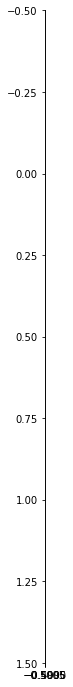

In [72]:
fig, ax = plt.subplots(figsize = (12,12))
cax = ax.imshow(results_xr)

plt.show()

In [54]:
dsm = dsm.astype('int16')

In [55]:
#add classification results to dataset
##replace with Geomediam 
Sentinal_time["class"] = results_xr
Sentinal_time["slope"] = dsm

Sentinal_time
#add smad/green to dataset?

<xarray.Dataset>
Dimensions:  (x: 2877, y: 2387)
Coordinates:
  * x        (x) float64 1.548e+06 1.548e+06 1.548e+06 1.548e+06 1.548e+06 ...
  * y        (y) float64 -3.951e+06 -3.951e+06 -3.951e+06 -3.951e+06 ...
    time     datetime64[ns] 2016-01-01T00:09:15.704000
Data variables:
    blue     (y, x) int16 564 575 554 575 521 491 438 408 428 523 592 592 ...
    green    (y, x) int16 731 716 706 750 678 594 562 532 653 764 766 811 ...
    red      (y, x) int16 929 925 902 969 866 735 701 543 615 802 965 1017 ...
    class    (y, x) int16 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 ...
    slope    (y, x) int16 54 49 44 40 38 37 35 33 31 27 23 19 18 17 17 16 15 ...
Attributes:
    crs:      EPSG:3577

In [57]:
#save dataset as netCDF to look at in QGIS
#write_geotiff(filename, dataset, profile_override=None, time_index=None)
helpers.write_geotiff('/g/data/u46/users/ck9738/Datasets/ML_for_smad_green/lst7_train_Ecan_slope2.tif',Sentinal_time)